### Consignes Partie II

[NNI](https://github.com/microsoft/nni/blob/master/README.md) est une boîte à outils AutoML gratuite et open source développée par Microsoft. Celle-ci permet de facilement utiliser des outils classiques d'hyperparamétrage pour rendre le plus efficace possible les algorithmes. Ici, nous nous intéresserons au jeu de données [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) et à Keras, une bibliothèque opensource écrite en python et permettant d'utiliser des algorithmes d'apprentissage automatique.

> A rendre pour le mardi 11 janvier 8h

## Liens utilisés

- https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/
- https://larevueia.fr/tensorflow/
- https://www.tensorflow.org/tutorials/keras/classification
- https://ichi.pro/fr/automl-reglage-des-hyperparametres-avec-nni-et-keras-281195637245647

## Mise en place des outils nécessaires (sur machine locale, ne pas tenir compte de cette partie)

### Sauvegarde data

#### Monter google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Sauvegarder dans google drive

In [3]:
! cp -r /content/drive/MyDrive/ml /content/
! cp -r /content/drive/MyDrive/.ngrok2/ /content/

#### Restaurer data depuis google drive

In [4]:
! cp -r ml /content/drive/MyDrive
! cp -r .ngrok2/ /content/drive/MyDrive/

### intallation de ngrok
Par défaut on n'a pas accès à l'adresse interne du colab. Cet outil va donc nous permettre par un mécanisme de reverse proxy d'obtenir une ip pour nni.

In [ ]:
! wget -q -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -qq ngrok-stable-linux-amd64.zip

### clonage du projet depuis github ou drive

In [ ]:
! cp -r /content/drive/MyDrive/ml /content/
! cp -r /content/drive/MyDrive/.ngrok2/ /content/

### Installation des librairiries nécessaires

In [ ]:
! pip install --quiet -r ml/requirements.txt

### Authentification ngrok

In [ ]:
! ./ngrok authtoken API_KEY

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


### Lancement de nni avec ngrok

In [ ]:
! nnictl stop; sleep 5; nnictl create --config ml/src/config.yml --port 5000 &
get_ipython().system_raw('./ngrok http 5000 &')

### recupération de l'ip public

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python -m json.tool | grep 'public_url'

In [ ]:
! nnictl create --config ml/src/config.yml --port 5000 &
get_ipython().system_raw('./ngrok http 5000 &')
# ne pas changer le port 4040, c'est le port interne de ngrok
! curl -s http://localhost:4040/api/tunnels | python -m json.tool | grep 'public_url'

### Arrêt du serveur

In [ ]:
! nnictl stop

## Description brève du jeu de données Fashion-MNIST

NNI propose un [tutoriel](https://github.com/microsoft/nni/tree/master/examples/trials/mnist-keras) permettant son utilisation pour la résolution du jeu de données MNIST initial (équivalent au jeu de données digits).

## Utiliser NNI et Keras pour construire un réseau de neurones efficace pour le jeu de données Fashion-MNIST : 

décrire le réseau de neurones utilisé, les hyperparamètres à instancier, le protocole d'hyperparamétrage et les résultats obtenus

Avant de continuer s'assurer d'avoir installer les libraries suivantes et pour `matplotlib` la version `3.1.1` qui semble la seule fonctionner chez moi pour générer les graphiques.
```
matplotlib==3.1.1
nni==2.5
tensorflow==2.7.0
```

si projet importé depuis le lien github. `git clone https://github.com/uNouss/projetML; cd projetML`.

L'installation se fait comme suit:

1. création d'un nouvelle environnement virtuelle  nommé `.venv` (facultative): `python3 -m venv .venv`; suivi de son activation: `source .venv/bin/activate`.
2. installation des libraries: `pip install -r requirements.txt` si un nouvelle environnement est crée sinon `python3 -m pip install -r requirements.txt`.

3. une fois les installations faites lancer **NNI** comme suit: `nnictl create --config src/config.yml -p 8080` et ouvrir l'url produite par cette commande, [127.1:8080](http://127.1:8080). Il lancera le script python situé dans `src/mnist-fashion.py` avec le fichier contenant l'espace de recherche `src/search_space.json` dans lequel sont défini les hyperparamètres.

### Chargement des données mnist-fashion depuis tensorflow

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import nni

In [8]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

fashion_mnist = tf.keras.datasets.fashion_mnist
(images_train, targets_train), (images_test, targets_test) = tf.keras.datasets.fashion_mnist.load_data()

In [9]:
targets_train, targets_test = targets_train.reshape(targets_train.shape[0], 1), targets_test.reshape(targets_test.shape[0], 1)

In [10]:
print('Fashion MNIST Dataset Shape:')
print(f'images_train: {images_train.shape}')
print(f'targets_train: {targets_train.shape}')
print(f'images_test:  {images_test.shape}')
print(f'targets_test:  {targets_test.shape}')

Fashion MNIST Dataset Shape:
images_train: (60000, 28, 28)
targets_train: (60000, 1)
images_test:  (10000, 28, 28)
targets_test:  (10000, 1)


Nous avons un jeu de données composés d'images de tailles 28x28, labelisées. Il se décompose comme suit:
- 60 000 en donnée d'entrainement et 10 000 en données de tests.
- les images_train et images_test contiennent les images;
- les targets_train et targets_test contiennent les labels des images.

Il existe 10 labels différents qui sont:

|Label|	Description|
|:----|:-----------|
|0	  |T-shirt     |
|1	  |Pantalon     |
|2	  |Pull    |
|3	  |Robe       |
|4	  |Manteau        |
|5	  |Sandale      |
|6	  |Chemise       |
|7	  |Sneaker     |
|8	  |Sac        |
|9	  |Bottes  |



### Affichage de quelques images du jeu de données d'entrainement.

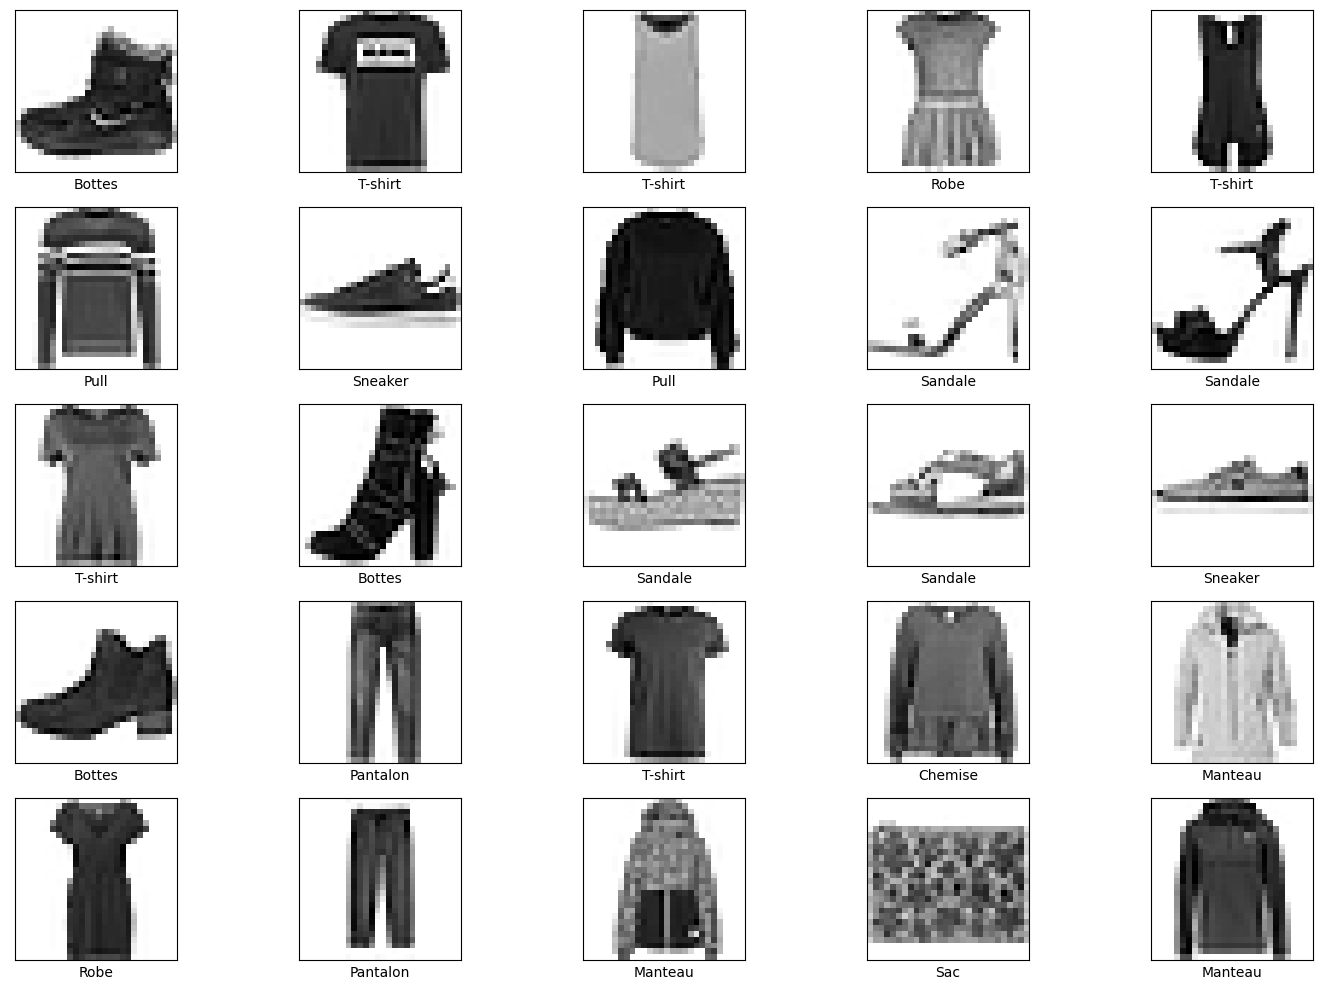

In [17]:
targets_names = ["T-shirt", "Pantalon", "Pull", "Robe", "Manteau", "Sandale", "Chemise", "Sneaker", "Sac", "Bottes"]

plt.figure(figsize=(15, 10), dpi=100)

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i], cmap=plt.cm.binary)
    plt.xlabel(targets_names[targets_train[i][0]])
plt.tight_layout()
plt.show()

### Repartitions des catégories et fréquences d'apparitions

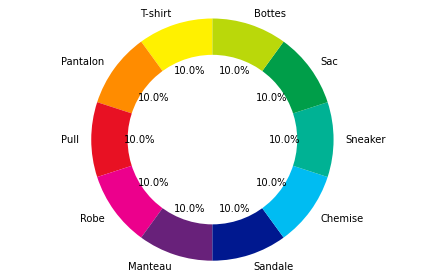

In [18]:
sizes = np.unique(targets_train, return_counts=True)[1]

# Choix des couleurs
colors = ['#fff100','#ff8c00','#e81123','#ec008c','#68217a', '#00188f', '#00bcf2','#00b294','#009e49','#bad80a']

# Construction du diagramme et affichage des labels et des #fréquences en pourcentage
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=targets_names, autopct='%1.1f%%', startangle=90)

# Tracé du cercle au milieu
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Affichage du diagramme
ax1.axis('equal')  
plt.tight_layout()
plt.show()

Nous constatons que les classes sont bien équilibrées. On peut donc utiliser l'`accuracy` comme mesure d'évaluation.




## Description du reseau de neurones




![archi-reseau](img/archi-reseau.png)

Figure: Architecture du réseau de neurone que nous avons essayé de reproduire (extrait du diapo)

#### Construction du modèle


Le code se trouve ici : [projet github](https://github.com/uNouss/projetML)

Nous allons faire un réseau de neurones composé de couches simples.

 1. Nous avons une première couche de convolution. Suivi d'une couche de pooling puis d'une autre couche de convolution. Ces trois premières couches vont permettre au reseau d'apprendre les caractéristiques intéressantes pour pouvoir discriminer les classes;
 2. une couche qui s'occupe d'applatir les images issues de la convolution et de les transformer en un vecteur pour preparer aux calculs suivants;
 3. une couche "fully connected" qui a comme entrée la sortie de la couche de l'étape precedente et comme sortie un vecteur de taille t neurones que nous ferons varier avec l'espace de recherche, suivi d'une fonction d'activation de type `relu`;
 4. La dernière de même nature que la précedente va nous permettre d'avoir la classe à laquelle correspond une image. Donc en sortie on aura un vecteur de taille 10 correspondant aux probabilités que l'image appartienne à chacune des classes.

Nous ferons aussi varier la méthode utilisée pour optimiser le reseau ( descente du gradient, adam).

#### Espace de recherche

Nous avons défini des hyperparamètres pour notre modèle. Nous faisons varier la méthode d'optimisation, le coefficient d'apprentissage, et le nombre de neurones de la couche dense.

```json
{
    "optimizer": {"_type": "choice","_value": ["SGD", "Adam"]},
    "learning_rate": {"_type": "quniform","_value": [0.001, 0.05, 0.01]},
    "nb_nodes": {"_type": "choice", "_value": [64, 128, 256, 512]},
}
```

Nous avons choisi de ne pas manipuler d'autres hyperparametres compte tenu du fait que nos machines ne tiennent pas la charge.




#### Modèle obtenu

Le modèle ayant la meilleure accuracy (0.9196) est celui qui utilise les hyperparamètres suivants: 

![meilleur accuracy](img/output-nni.png)
Figure: ligne ayant la meilleur performance (en l'état actuelle de l'éxecution, après 13 itérations, nous avons mis 100 à peu près)

dont les détails sont les suivantes.
```json
{
    "optimizer": "Adam",
    "learning_rate": 0.001,
    "nb_nodes": 128,
    "metrics": "accuracy",
    "activation_function": "relu"
}
```

Nous avons perdu la connexion au serveur avant que les calculs soient terminés.
